In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(70.0, 78.82417582417582, 85.0)]


In [129]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2016-08-01'
end_date = '2017-08-01'

print(calc_temps(start_date, end_date))

[(58.0, 74.64288840262581, 87.0)]


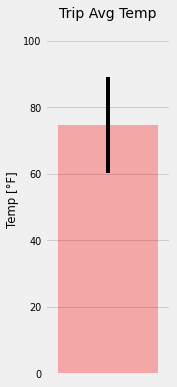

In [130]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin, tavg, tmax = calc_temps(start_date, end_date)[0]
yerr = (tmax-tmin)/2

plt.figure(figsize=(2,6))
plt.bar(x=.5, height=tavg, yerr=yerr, color='red', alpha=0.3)

plt.title("Trip Avg Temp", size="medium")
plt.ylabel("Temp [°F]", size="small")

plt.xlim(0,1)
plt.ylim(0,100+5)
plt.xticks(ticks=[])
plt.yticks(ticks=range(0,100+1,20), size="x-small")

plt.show()

### Daily Rainfall Average

In [92]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

slct = [Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp)]

results = session.query(*slct).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

In [93]:
results

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 157.91000000000005),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 79.49000000000005),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 54.39000000000004),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 39.800000000000004),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 34.25999999999999),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 17.199999999999992),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.77)]

In [94]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
end = dt.datetime.strptime(end_date, "%Y-%m-%d").date()
date_range = [start + dt.timedelta(days=i) for i in range(0, (end-start).days+1)]

# Strip off the year and save a list of strings in the format %m-%d
string_list = [date_range[i].strftime("%m-%d") for i in range(len(date_range))]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for string in string_list:
    normals.append(np.ravel(daily_normals(string)))

In [141]:
date_range

[datetime.date(2018, 1, 1),
 datetime.date(2018, 1, 2),
 datetime.date(2018, 1, 3),
 datetime.date(2018, 1, 4),
 datetime.date(2018, 1, 5),
 datetime.date(2018, 1, 6),
 datetime.date(2018, 1, 7)]

In [142]:
normals

[array([62.        , 69.15384615, 77.        ]),
 array([60.        , 69.39622642, 77.        ]),
 array([62.        , 68.90909091, 77.        ]),
 array([58., 70., 76.]),
 array([56.        , 67.96428571, 76.        ]),
 array([61.        , 68.96491228, 76.        ]),
 array([57.        , 68.54385965, 76.        ])]

In [143]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=date_range, columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


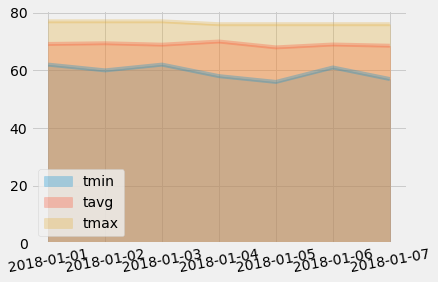

In [145]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, alpha=0.3, rot=10)
plt.show()

## Close Session

In [85]:
session.close()